# 1-DoF Planar (Functional)

## GETTING THIS ALL TO WORK

Aight, so we have some major issues with the approaches used so far:

1. Using Lagrangian modelling technique requires Lagange multipliers, which I frankly can't learn in a week
2. The simulation approach used to generate the graphs above have issues where, since the time step is so small, dividing by the time step squared results in absolutely massive accelerations

Here is my new approach which will hopefully work:

1. Get the positions of x0 through x5 and y0 through y5 as done at the top
2. Polyfit these to get positions as functions of theta, also as done above
3. Derive twice with respect to time, giving the accelerations as funcitons of theta and time (since theta is a function of time). Since the velocity is constant in each phase and the acceleration of theta is zero (except at speed transitions, which we can safely ignore), this should give a decent representation of the cartesian accelerations
4. Calculate motor torque using the equations developed in OneNote
5. Calculate work, etc.
6. ???
7. Profit

This is a new doc so as to seperate it from the very broken code from before

minimum value of Node 5 should be -0.35m: -0.34999999996298364


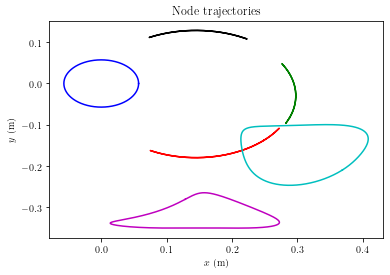

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font',family='serif')
import math as math
import sympy as sp

# functions for solving four bar linkages
def solve_four_bar_linkage_y(a, b, c, d, e, A_x, A_y):
    alpha = (-(a**2) + b**2 -(c**2) + d**2 + e**2) / (2 * (d - A_x))
    P = 1 + ((e - A_y)**2) / ((d - A_x)**2)
    Q = (2 * (e - A_y) * (d - alpha)) / (d - A_x) - (2 * e)
    R = (alpha - d)**2 + e**2 - c**2
    B_y_1 = (-Q + math.sqrt(Q**2 - 4*P*R)) / (2*P)
    B_x_1 = alpha - (B_y_1 * (e - A_y)) / (d - A_x)
    B_y_2 = (-Q - math.sqrt(Q**2 - 4*P*R)) / (2*P)
    B_x_2 = alpha - (B_y_2 * (e - A_y)) / (d - A_x)
    return [B_x_1, B_y_1, B_x_2, B_y_2]

def solve_four_bar_linkage_x(a, b, c, d, e, A_x, A_y):
    alpha = (-(a**2) + b**2 -(c**2) + d**2 + e**2) / (2 * (e - A_y))
    P = 1 + ((d - A_x)**2) / ((e - A_y)**2)
    Q = (2 * (d - A_x) * (e - alpha)) / (e - A_y) - (2 * d)
    R = (alpha - e)**2 + d**2 - c**2
    B_x_1 = (-Q + math.sqrt(Q**2 - 4*P*R)) / (2*P)
    B_y_1 = alpha - (B_x_1 * (d - A_x)) / (e - A_y)
    B_x_2 = (-Q - math.sqrt(Q**2 - 4*P*R)) / (2*P)
    B_y_2 = alpha - (B_x_2 * (d - A_x)) / (e - A_y)
    return [B_x_1, B_y_1, B_x_2, B_y_2]

# pre-scaled link lengths, taken from other Jupyter notebook
ell0 = 0.057168439518905365
ell1 = 0.19056146506301788
ell2 = 0.21266659501032797
ell3 = 0.1501624344696581
ell4 = 0.25039776509280554
ell5 = 0.18675023576175753
ell6 = 0.23591509374801614
ell7 = 0.13987211535625513
ell8 = 0.14978131153953206
ell9 = 0.15816601600230484
ell10= 0.15283029498054035
xpin = 0.14482671344789358
ypin = -0.02972758854983079

# higher number = higher precision. consistent number for all simulations
steps = 60000 #100000
# how close to the ground is considered contact
margin = 0.0035

#-------------------------------#
#                               #
#       First Simulation        #
#                               #
#-------------------------------#
# this sim is to determine stride length and required velocities
# during ground and air phase of walking

# indices of when foot makes contact with the ground and when it takes off
i_begin = -1
i_end = -1

# Initialize arrays to hold node position values
theta = np.empty(steps)
n0x = np.empty(steps)
n0y = np.empty(steps)
n1x = np.empty(steps)
n1y = np.empty(steps)
n2x = np.empty(steps)
n2y = np.empty(steps)
n3x = np.empty(steps)
n3y = np.empty(steps)
n4x = np.empty(steps)
n4y = np.empty(steps)
n5x = np.empty(steps)
n5y = np.empty(steps)

# clockwise rotation from 6pi to 0pi (3 steps)
for j in range(steps, 0, -1):
    i = steps - j
    theta[i] = 6 * math.pi * (j / steps)
    # NODE 0
    x0 = ell0 * math.cos(theta[i])
    y0 = ell0 * math.sin(theta[i])
    n0x[i] = x0
    n0y[i] = y0
    # NODE 1: take higher value of Y
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_y(ell0,ell1,ell9,xpin,ypin,x0,y0)
    n1x[i] = sol1x
    n1y[i] = sol1y
    # NODE 2: take larger value of x
    d = xpin - x0
    e = ypin - y0
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_x(ell1,ell2,ell10,d,e,n1x[i]-x0,n1y[i]-y0)
    n2x[i] = sol1x + x0
    n2y[i] = sol1y + y0
    # NODE 3: take the smaller value of y
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_y(ell0,ell6,ell8,xpin,ypin,x0,y0)
    n3x[i] = sol2x
    n3y[i] = sol2y
    # NODE 4: take larger value of x
    d = n3x[i] - xpin
    e = n3y[i] - ypin
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_x(ell10,ell3,ell7,d,e,n2x[i]-xpin,n2y[i]-ypin)
    n4x[i] = sol1x + xpin
    n4y[i] = sol1y + ypin
    # NODE 5: take the smaller value of y
    d = n3x[i] - n2x[i]
    e = n3y[i] - n2y[i]
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_y(ell3,ell4,ell5,d,e,n4x[i]-n2x[i],n4y[i]-n2y[i])
    n5x[i] = sol2x + n2x[i]
    n5y[i] = sol2y + n2y[i]
    # foot contact is begun when y drops under margin
    if (n5y[i] <= -0.35+margin and i_begin == -1):
        i_begin = i
    # foot contact has ended when y rises above the margin
    elif (n5y[i] >= -0.35+margin and i_begin != -1 and i_end == -1):
        i_end = i
    
min_n5y = 9999
for i in range(0,steps,1):
    if (n5y[i] < min_n5y):
        min_n5y = n5y[i]
print('minimum value of Node 5 should be -0.35m:',min_n5y)
    
fig_nodes = plt.figure()
ax_nodes = fig_nodes.add_subplot()
ax_nodes.plot(n0x[0:(steps//3)],n0y[0:(steps//3)],'b',n1x[0:(steps//3)],n1y[0:(steps//3)],'k',n2x[0:(steps//3)],n2y[0:(steps//3)],'g',n3x[0:(steps//3)],n3y[0:(steps//3)],'r',n4x[0:(steps//3)],n4y[0:(steps//3)],'c',n5x[0:(steps//3)],n5y[0:(steps//3)],'m')
ax_nodes.set_xlabel(r'$x$ (m)')
ax_nodes.set_ylabel(r'$y$ (m)')
ax_nodes.set_title(r'Node trajectories')
plt.savefig('imgout/4_jansen-node-positions-togther.eps',dpi=600)

In [2]:
stride_length = n5x[i_begin]-n5x[i_end]
theta_ground = theta[i_begin]
theta_air = theta[i_end]

# leg stride occupies 3/4 of the time to complete a cycle as per (Hutter, 2014)
distance_cycle = stride_length * (1 + (1/3))
# robot walking speed is 0.3m/s
time_cycle = distance_cycle / 0.3
# the time spent with ground contact should present 3/4 of the total time
time_ground = time_cycle * (3/4)
time_air = time_cycle * (1/4)
# size of each time step in the simulation, now for 3 cycles
time_step = 3*time_cycle / steps

velocity_ground = abs(theta[i_begin] - theta[i_end]) / time_ground
velocity_air = (2*np.pi - abs(theta[i_begin] - theta[i_end])) / time_air

print('target cycle time: ',time_cycle)
print('target ground time: ',time_ground)
print('target air time: ',time_air)
print('ground velocity (rad/s): ',velocity_ground)
print('air velocity (rad/s)',velocity_air)
print('time step size:',time_step)

target cycle time:  0.9576184600172216
target ground time:  0.7182138450129162
target air time:  0.2394046150043054
ground velocity (rad/s):  3.6913658219951855
air velocity (rad/s) 15.170949259895607
time step size: 4.788092300086108e-05


Now that we know how fast $\theta$ must be during the stance (ground) and flight (air) phases, as well as when the phases start and end, we will re-simulate using these speeds, and find the position of each node as a function of time.

minimum value of Node 5 should be -0.35m: -0.34999999999182857


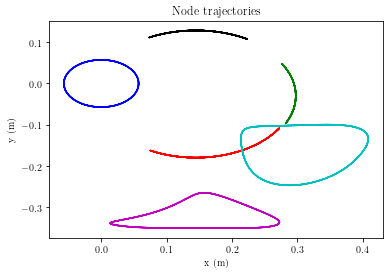

In [3]:
# Initialize arrays to hold node position values
time = np.empty(steps)
theta = np.empty(steps)
n0x = np.empty(steps)
n0y = np.empty(steps)
n1x = np.empty(steps)
n1y = np.empty(steps)
n2x = np.empty(steps)
n2y = np.empty(steps)
n3x = np.empty(steps)
n3y = np.empty(steps)
n4x = np.empty(steps)
n4y = np.empty(steps)
n5x = np.empty(steps)
n5y = np.empty(steps)

# Initial conditions
time[0] = 0
theta[0] = 6 * np.pi
# NODE 0
x0 = ell0 * math.cos(theta[0])
y0 = ell0 * math.sin(theta[0])
n0x[0] = x0
n0y[0] = y0
# NODE 1: take higher value of Y
[sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_y(ell0,ell1,ell9,xpin,ypin,x0,y0)
n1x[0] = sol1x
n1y[0] = sol1y
# NODE 2: take larger value of x
d = xpin - x0
e = ypin - y0
[sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_x(ell1,ell2,ell10,d,e,n1x[0]-x0,n1y[0]-y0)
n2x[0] = sol1x + x0
n2y[0] = sol1y + y0
# NODE 3: take the smaller value of y
[sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_y(ell0,ell6,ell8,xpin,ypin,x0,y0)
n3x[0] = sol2x
n3y[0] = sol2y
# NODE 4: take larger value of x
d = n3x[0] - xpin
e = n3y[0] - ypin
[sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_x(ell10,ell3,ell7,d,e,n2x[0]-xpin,n2y[0]-ypin)
n4x[0] = sol1x + xpin
n4y[0] = sol1y + ypin
# NODE 5: take the smaller value of y
d = n3x[0] - n2x[0]
e = n3y[0] - n2y[0]
[sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_y(ell3,ell4,ell5,d,e,n4x[0]-n2x[0],n4y[0]-n2y[0])
n5x[0] = sol2x + n2x[0]
n5y[0] = sol2y + n2y[0]

i_begin = -1
i_end = -1

for j in range(steps, 0, -1):
    i = steps - j
    time[i] = 3*time_cycle * (i / steps)
    # NEW THETA
    if (n5y[i-1] <= -0.35+margin):
        # on the ground, clockwise
        theta[i] = theta[i-1] - velocity_ground * time_step
    else:
        # in the air, clockwise
        theta[i] = theta[i-1] - velocity_air * time_step
    # NODE 0
    x0 = ell0 * np.cos(theta[i])
    y0 = ell0 * np.sin(theta[i])
    n0x[i] = x0
    n0y[i] = y0
    # NODE 1: take higher value of Y
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_y(ell0,ell1,ell9,xpin,ypin,x0,y0)
    n1x[i] = sol1x
    n1y[i] = sol1y
    # NODE 2: take larger value of x
    d = xpin - x0
    e = ypin - y0
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_x(ell1,ell2,ell10,d,e,n1x[i]-x0,n1y[i]-y0)
    n2x[i] = sol1x + x0
    n2y[i] = sol1y + y0
    # NODE 3: take the smaller value of y
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_y(ell0,ell6,ell8,xpin,ypin,x0,y0)
    n3x[i] = sol2x
    n3y[i] = sol2y
    # NODE 4: take larger value of x
    d = n3x[i] - xpin
    e = n3y[i] - ypin
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_x(ell10,ell3,ell7,d,e,n2x[i]-xpin,n2y[i]-ypin)
    n4x[i] = sol1x + xpin
    n4y[i] = sol1y + ypin
    # NODE 5: take the smaller value of y
    d = n3x[i] - n2x[i]
    e = n3y[i] - n2y[i]
    [sol1x,sol1y,sol2x,sol2y] = solve_four_bar_linkage_y(ell3,ell4,ell5,d,e,n4x[i]-n2x[i],n4y[i]-n2y[i])
    n5x[i] = sol2x + n2x[i]
    n5y[i] = sol2y + n2y[i]
    # foot contact is begun when y drops under margin
    if (n5y[i] <= -0.35+margin and i_begin == -1):
        i_begin = i
    # foot contact has ended when y rises above the margin
    elif (n5y[i] >= -0.35+margin and i_begin != -1 and i_end == -1):
        i_end = i

# Some verification
min_n5y = 9999
for i in range(0,steps,1):
    if (n5y[i] < min_n5y):
        min_n5y = n5y[i]
print('minimum value of Node 5 should be -0.35m:',min_n5y)
    
fig_nodes = plt.figure()
ax_nodes = fig_nodes.add_subplot()
ax_nodes.plot(n0x,n0y,'b',n1x,n1y,'k',n2x,n2y,'g',n3x,n3y,'r',n4x,n4y,'c',n5x,n5y,'m')
ax_nodes.set_xlabel('x (m)')
ax_nodes.set_ylabel('y (m)')
ax_nodes.set_title('Node trajectories')
fig_nodes.show()

Our graph output looks identical; this suggests that the second run of the simulation worked! Now we can polyfit each node position as a function of time

In [4]:
polydeg = 15
# polynomial fits, returns polynomial coefficients, residuals and unused values
# a, b and c. the 3rd argument indicates the max order of the polynomial
# coefficients in the series fn_X are returned in order of greatest to lowest polynome (x^3, x^2, x^1, x^0)
# residual (rNx) returned to determined quality of the fit
c0x,r0x,a,b,c = np.polyfit(time[0:(steps//3)],n0x[(steps//3):((2*steps)//3)],polydeg,full=True)
c0y,r0y,a,b,c = np.polyfit(time[0:(steps//3)],n0y[(steps//3):((2*steps)//3)],polydeg,full=True)
c1x,r1x,a,b,c = np.polyfit(time[0:(steps//3)],n1x[(steps//3):((2*steps)//3)],polydeg,full=True)
c1y,r1y,a,b,c = np.polyfit(time[0:(steps//3)],n1y[(steps//3):((2*steps)//3)],polydeg,full=True)
c2x,r2x,a,b,c = np.polyfit(time[0:(steps//3)],n2x[(steps//3):((2*steps)//3)],polydeg,full=True)
c2y,r2y,a,b,c = np.polyfit(time[0:(steps//3)],n2y[(steps//3):((2*steps)//3)],polydeg,full=True)
c3x,r3x,a,b,c = np.polyfit(time[0:(steps//3)],n3x[(steps//3):((2*steps)//3)],polydeg,full=True)
c3y,r3y,a,b,c = np.polyfit(time[0:(steps//3)],n3y[(steps//3):((2*steps)//3)],polydeg,full=True)
c4x,r4x,a,b,c = np.polyfit(time[0:(steps//3)],n4x[(steps//3):((2*steps)//3)],polydeg,full=True)
c4y,r4y,a,b,c = np.polyfit(time[0:(steps//3)],n4y[(steps//3):((2*steps)//3)],polydeg,full=True)
c5x,r5x,a,b,c = np.polyfit(time[0:(steps//3)],n5x[(steps//3):((2*steps)//3)],polydeg,full=True)
c5y,r5y,a,b,c = np.polyfit(time[0:(steps//3)],n5y[(steps//3):((2*steps)//3)],polydeg,full=True)
# poly1d version of each
p0x = np.poly1d(c0x)
p0y = np.poly1d(c0y)
p1x = np.poly1d(c1x)
p1y = np.poly1d(c1y)
p2x = np.poly1d(c2x)
p2y = np.poly1d(c2y)
p3x = np.poly1d(c3x)
p3y = np.poly1d(c3y)
p4x = np.poly1d(c4x)
p4y = np.poly1d(c4y)
p5x = np.poly1d(c5x)
p5y = np.poly1d(c5y)

# Comparative graph to ensure the polyfit is correct
pfit0x = np.empty(steps) 
pfit0y = np.empty(steps)
pfit1x = np.empty(steps)
pfit1y = np.empty(steps)
pfit2x = np.empty(steps)
pfit2y = np.empty(steps)
pfit3x = np.empty(steps)
pfit3y = np.empty(steps)
pfit4x = np.empty(steps)
pfit4y = np.empty(steps)
pfit5x = np.empty(steps)
pfit5y = np.empty(steps)
for i in range(0,steps,1):
    if (i >= steps//3 and i < (2*steps)//3):
        # during second iteration
        time_i = time[i-(steps//3)]
    elif (i >= (2*steps)//3):
        # during 3rd iteration
        time_i = time[i-((2*steps)//3)]
    else:
        time_i = time[i]
    pfit0x[i] = p0x(time_i)
    pfit0y[i] = p0y(time_i)
    pfit1x[i] = p1x(time_i)
    pfit1y[i] = p1y(time_i)
    pfit2x[i] = p2x(time_i)
    pfit2y[i] = p2y(time_i)
    pfit3x[i] = p3x(time_i)
    pfit3y[i] = p3y(time_i)
    pfit4x[i] = p4x(time_i)
    pfit4y[i] = p4y(time_i)
    pfit5x[i] = p5x(time_i)
    pfit5y[i] = p5y(time_i)

In [ ]:
fig3 = plt.figure(figsize=(8,4))
#fig3.tight_layout()
fig3.suptitle('Node positions as a function of time')
a3_0 = fig3.add_subplot(2,3,1)
a3_0.plot(time,n0x,'b',label='x')
a3_0.plot(time,pfit0x,'c--',label='x (fit)')
a3_0.plot(time,n0y,'r',label='y')
a3_0.plot(time,pfit0y,'m--',label='y (fit)')
#a3_0.legend()
#a3_0.set_xlabel('time')
a3_0.set_title('Node 0')
a3_1 = fig3.add_subplot(2,3,2)
a3_1.plot(time,n1x,'b',label='x')
a3_1.plot(time,pfit1x,'c--',label='x (fit)')
a3_1.plot(time,n1y,'r',label='y')
a3_1.plot(time,pfit1y,'m--',label='y (fit)')
#a3_1.legend()
#a3_1.set_xlabel('time')
a3_1.set_title('Node 1')
a3_2 = fig3.add_subplot(2,3,3)
a3_2.plot(time,n2x,'b',label='x')
a3_2.plot(time,pfit2x,'c--',label='x (fit)')
a3_2.plot(time,n2y,'r',label='y')
a3_2.plot(time,pfit2y,'m--',label='y (fit)')
#a3_2.legend()
#a3_2.set_xlabel('time')
a3_2.set_title('Node 2')
a3_3 = fig3.add_subplot(2,3,4)
a3_3.plot(time,n3x,'b',label='x')
a3_3.plot(time,pfit3x,'c--',label='x (fit)')
a3_3.plot(time,n3y,'r',label='y')
a3_3.plot(time,pfit3y,'m--',label='y (fit)')
#a3_3.legend()
#a3_3.set_xlabel('time')
a3_3.set_title('Node 3')
a3_4 = fig3.add_subplot(2,3,5)
a3_4.plot(time,n4x,'b',label='x')
a3_4.plot(time,pfit4x,'c--',label='x (fit)')
a3_4.plot(time,n4y,'r',label='y')
a3_4.plot(time,pfit4y,'m--',label='y (fit)')
#a3_4.legend()
#a3_4.set_xlabel('time')
a3_4.set_title('Node 4')
a3_5 = fig3.add_subplot(2,3,6)
a3_5.plot(time,n5x,'b',label='x')
a3_5.plot(time,pfit5x,'c--',label='x (fit)')
a3_5.plot(time,n5y,'r',label='y')
a3_5.plot(time,pfit5y,'m--',label='y (fit)')
#a3_5.legend()
#a3_5.set_xlabel('time')
a3_5.set_title('Node 5')
fig3.show()
plt.savefig('imgout/4_node-positions-fct-of-time.eps',dpi=600)

Now that we have a pretty well fit polynomial representation of each node position as a function of time, we can derive the symbolic representation of each twice with respect to time

In [5]:
# lazily generate the symbolic representation of each one
polyfunc = [c0x,c0y,c1x,c1y,c2x,c2y,c3x,c3y,c4x,c4y,c5x,c5y]
print(len(c0y))
print(polyfunc[1])
# iterate over each polyfit function
for i in range(len(polyfunc)):
    if (i%2 == 0):
        print("x", end='')
    else:
        print("y", end='')
    print(i//2,"= ", end='')
    # iterate over all coefficients in a polyfit function
    for j in range(len(polyfunc[i])):
        if (j == len(polyfunc[i])-1):
            print(str(polyfunc[i][j]),"* t**"+str(len(polyfunc[i])-j-1),end='')
        else:
            print(str(polyfunc[i][j]),"* t**"+str(len(polyfunc[i])-j-1),"+ ",end='')
    print()

16
[-4.23882676e+05  3.05339594e+06 -9.88600471e+06  1.89975983e+07
 -2.40949753e+07  2.12101970e+07 -1.32579440e+07  5.91207668e+06
 -1.85874158e+06  3.98879251e+05 -5.45680026e+04  4.06195090e+03
 -9.15377370e+01 -6.34420525e-01 -7.91083513e-01 -5.41986908e-04]
x0 = 205272.6813915461 * t**15 + -1096655.2759765568 * t**14 + 2232740.8880685065 * t**13 + -1544584.4552774318 * t**12 + -1899557.2077575342 * t**11 + 5538372.299112158 * t**10 + -6309524.789331387 * t**9 + 4379667.841915571 * t**8 + -2023656.1466368388 * t**7 + 634350.7250268264 * t**6 + -132772.33474911435 * t**5 + 17633.376826044037 * t**4 + -1331.2315848669693 * t**3 + 44.81104455146278 * t**2 + -0.8076025273081177 * t**1 + 0.060115682301152 * t**0
y0 = -423882.6759102075 * t**15 + 3053395.9441675735 * t**14 + -9886004.706213322 * t**13 + 18997598.276182447 * t**12 + -24094975.280565623 * t**11 + 21210197.005430575 * t**10 + -13257943.953917189 * t**9 + 5912076.677308458 * t**8 + -1858741.5811294669 * t**7 + 398879.250957

In [6]:
# just grab the equations from above and BOOM, ez

t = sp.symbols('t')
x0 = 205272.6813915461 * t**15 + -1096655.2759765568 * t**14 + 2232740.8880685065 * t**13 + -1544584.4552774318 * t**12 + -1899557.2077575342 * t**11 + 5538372.299112158 * t**10 + -6309524.789331387 * t**9 + 4379667.841915571 * t**8 + -2023656.1466368388 * t**7 + 634350.7250268264 * t**6 + -132772.33474911435 * t**5 + 17633.376826044037 * t**4 + -1331.2315848669693 * t**3 + 44.81104455146278 * t**2 + -0.8076025273081177 * t**1 + 0.060115682301152 * t**0
y0 = -423882.6759102075 * t**15 + 3053395.9441675735 * t**14 + -9886004.706213322 * t**13 + 18997598.276182447 * t**12 + -24094975.280565623 * t**11 + 21210197.005430575 * t**10 + -13257943.953917189 * t**9 + 5912076.677308458 * t**8 + -1858741.5811294669 * t**7 + 398879.25095787836 * t**6 + -54568.00259285669 * t**5 + 4061.950897251578 * t**4 + -91.53773700307275 * t**3 + -0.6344205249240127 * t**2 + -0.7910835125657569 * t**1 + -0.0005419869078101833 * t**0
x1 = 202566.31087706843 * t**15 + -1215364.5198755001 * t**14 + 3174544.0471853125 * t**13 + -4710478.12936862 * t**12 + 4334449.889205169 * t**11 + -2528193.2567424774 * t**10 + 926740.0156978803 * t**9 + -234564.35349919432 * t**8 + 82793.0717690999 * t**7 + -48905.65534111101 * t**6 + 20998.389296249614 * t**5 + -5262.793468482855 * t**4 + 719.7201047372678 * t**3 + -41.776076561454445 * t**2 + -0.6853333912539298 * t**1 + 0.20831790006619666 * t**0
y1 = -569588.2032052802 * t**15 + 4120135.942274276 * t**14 + -13465382.325527592 * t**13 + 26287454.172361672 * t**12 + -34144720.47182569 * t**11 + 31101815.901856173 * t**10 + -20395192.619571682 * t**9 + 9724083.35754115 * t**8 + -3360719.211950504 * t**7 + 828343.200135105 * t**6 + -140757.32404470295 * t**5 + 15465.171324178102 * t**4 + -960.2266783159682 * t**3 + 22.24519585107258 * t**2 + 0.27849195343313393 * t**1 + 0.11504875806334422 * t**0
x2 = -536467.1376867453 * t**15 + 3896269.8179142494 * t**14 + -12783899.057643946 * t**13 + 25050557.61925693 * t**12 + -32650310.218146686 * t**11 + 29829884.924442742 * t**10 + -19607096.883019708 * t**9 + 9361368.789513089 * t**8 + -3235253.6891384013 * t**7 + 795626.4513227317 * t**6 + -134399.95355182272 * t**5 + 14580.801105971062 * t**4 + -880.6040342737504 * t**3 + 18.821940095899265 * t**2 + 0.22542679702082905 * t**1 + 0.2884153104640278 * t**0
y2 = -231138.39089108774 * t**15 + 1430984.1906665072 * t**14 + -3907767.188036068 * t**13 + 6195102.90946694 * t**12 + -6326663.302771947 * t**11 + 4393676.91289048 * t**10 + -2176204.2788545117 * t**9 + 837705.3884570121 * t**8 + -291181.5722758765 * t**7 + 99249.02925230998 * t**6 + -29099.03035439871 * t**5 + 6047.055493684237 * t**4 + -754.3532693557958 * t**3 + 41.6801469702563 * t**2 + 0.678323652675741 * t**1 + -0.08184203846754722 * t**0
x3 = -46472.37216142085 * t**15 + 467828.07017147366 * t**14 + -2068868.637399407 * t**13 + 5330835.353488567 * t**12 + -8943539.538802462 * t**11 + 10325003.520712154 * t**10 + -8436428.023471637 * t**9 + 4931793.445335044 * t**8 + -2055332.6871523887 * t**7 + 598972.5419832123 * t**6 + -116992.29079787464 * t**5 + 14012.26954951948 * t**4 + -812.4135836121011 * t**3 + -0.3783367430776928 * t**2 + 1.085931600398961 * t**1 + 0.25314984290291126 * t**0
y3 = -575163.3921189174 * t**15 + 4134140.246920214 * t**14 + -13387723.096674763 * t**13 + 25804255.479281362 * t**12 + -32934808.132125683 * t**11 + 29284220.602509245 * t**10 + -18563867.17798842 * t**9 + 8426293.150882188 * t**8 + -2700577.033696408 * t**7 + 586512.0536617431 * t**6 + -77690.9340519635 * t**5 + 4099.896286549053 * t**4 + 373.3329975011306 * t**3 + -67.45720139414198 * t**2 + 2.588097956511154 * t**1 + -0.13834890704934474 * t**0
x4 = -854616.4535566501 * t**15 + 6403154.083324545 * t**14 + -21774353.783552986 * t**13 + 44431465.53199525 * t**12 + -60593495.16981324 * t**11 + 58201543.88185624 * t**10 + -40411461.93674026 * t**9 + 20476670.48183118 * t**8 + -7543679.370434064 * t**7 + 1985508.1705354296 * t**6 + -360051.13020539406 * t**5 + 41958.826559475754 * t**4 + -2701.0680968261136 * t**3 + 56.70330754921397 * t**2 + 1.0258706115893022 * t**1 + 0.37236129740147167 * t**0
y4 = -1224193.3167138393 * t**15 + 8652211.724461047 * t**14 + -27617687.403694548 * t**13 + 52657498.05815122 * t**12 + -66835248.70642021 * t**11 + 59567404.14759089 * t**10 + -38314334.76066449 * t**9 + 17992601.7413462 * t**8 + -6165637.151817076 * t**7 + 1522620.307564094 * t**6 + -263495.1139973199 * t**5 + 30245.814373549903 * t**4 + -2039.4912163512981 * t**3 + 51.94108734046929 * t**2 + 1.8688243233444612 * t**1 + -0.20930578811726008 * t**0
x5 = -731544.790544802 * t**15 + 5171447.16589241 * t**14 + -16669661.174957518 * t**13 + 32479737.412635576 * t**12 + -42734282.37241624 * t**11 + 40143390.5923326 * t**10 + -27725384.30942899 * t**9 + 14262429.147760805 * t**8 + -5465052.496842216 * t**7 + 1540431.0795721142 * t**6 + -310644.35173950484 * t**5 + 42583.05288675027 * t**4 + -3594.7274544391457 * t**3 + 144.98276277016194 * t**2 + 0.15034821966733036 * t**1 + 0.13444017073530934 * t**0
y5 = 627257.254194461 * t**15 + -4644420.529073015 * t**14 + 15594828.335586684 * t**13 + -31412570.203598198 * t**12 + 42314050.204769984 * t**11 + -40226394.673385225 * t**10 + 27759617.77778375 * t**9 + -14086683.355698641 * t**8 + 5266436.015506182 * t**7 + -1439032.5523016748 * t**6 + 281967.2470491883 * t**5 + -38262.55361632691 * t**4 + 3372.5541496565193 * t**3 + -167.91376419117822 * t**2 + 2.8191033672779575 * t**1 + -0.2805349232200386 * t**0

# symbolic first derivative (didn't bother with s since not used again)
x0d = x0.diff(t)
y0d = y0.diff(t)
x1d = x1.diff(t)
y1d = y1.diff(t)
x2d = x2.diff(t)
y2d = y2.diff(t)
x3d = x3.diff(t)
y3d = y3.diff(t)
x4d = x4.diff(t)
y4d = y4.diff(t)
x5d = x5.diff(t)
y5d = y5.diff(t)

# symbolic second derivative (thus the s)
x0dd_s = x0d.diff(t)
y0dd_s = y0d.diff(t)
x1dd_s = x1d.diff(t)
y1dd_s = y1d.diff(t)
x2dd_s = x2d.diff(t)
y2dd_s = y2d.diff(t)
x3dd_s = x3d.diff(t)
y3dd_s = y3d.diff(t)
x4dd_s = x4d.diff(t)
y4dd_s = y4d.diff(t)
x5dd_s = x5d.diff(t)
y5dd_s = y5d.diff(t)

# code representation of each
x0dd = sp.lambdify(t,x0dd_s)
y0dd = sp.lambdify(t,y0dd_s)
x1dd = sp.lambdify(t,x1dd_s)
y1dd = sp.lambdify(t,y1dd_s)
x2dd = sp.lambdify(t,x2dd_s)
y2dd = sp.lambdify(t,y2dd_s)
x3dd = sp.lambdify(t,x3dd_s)
y3dd = sp.lambdify(t,y3dd_s)
x4dd = sp.lambdify(t,x4dd_s)
y4dd = sp.lambdify(t,y4dd_s)
x5dd = sp.lambdify(t,x5dd_s)
y5dd = sp.lambdify(t,y5dd_s)

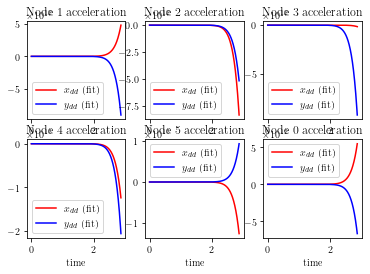

In [7]:
fig3 = plt.figure()
a_acc1 = plt.subplot(231)
a_acc1.plot(time,x1dd(np.asarray(time)),'r',label='$x_{dd}$ (fit)')
a_acc1.plot(time,y1dd(np.asarray(time)),'b',label='$y_{dd}$ (fit)')
a_acc1.legend()
a_acc1.set_xlabel('time')
a_acc1.set_title('Node 1 acceleration')
a_acc2 = plt.subplot(232)
a_acc2.plot(time,x2dd(np.asarray(time)),'r',label='$x_{dd}$ (fit)')
a_acc2.plot(time,y2dd(np.asarray(time)),'b',label='$y_{dd}$ (fit)')
a_acc2.legend()
a_acc2.set_xlabel('time')
a_acc2.set_title('Node 2 acceleration')
a_acc3 = plt.subplot(233)
a_acc3.plot(time,x3dd(np.asarray(time)),'r',label='$x_{dd}$ (fit)')
a_acc3.plot(time,y3dd(np.asarray(time)),'b',label='$y_{dd}$ (fit)')
a_acc3.legend()
a_acc3.set_xlabel('time')
a_acc3.set_title('Node 3 acceleration')
a_acc4 = plt.subplot(234)
a_acc4.plot(time,x4dd(np.asarray(time)),'r',label='$x_{dd}$ (fit)')
a_acc4.plot(time,y4dd(np.asarray(time)),'b',label='$y_{dd}$ (fit)')
a_acc4.legend()
a_acc4.set_xlabel('time')
a_acc4.set_title('Node 4 acceleration')
a_acc5 = plt.subplot(235)
a_acc5.plot(time,x5dd(np.asarray(time)),'r',label='$x_{dd}$ (fit)')
a_acc5.plot(time,y5dd(np.asarray(time)),'b',label='$y_{dd}$ (fit)')
a_acc5.legend()
a_acc5.set_xlabel('time')
a_acc5.set_title('Node 5 acceleration')
a_acc1 = plt.subplot(236)
a_acc1.plot(time,x0dd(np.asarray(time)),'r',label='$x_{dd}$ (fit)')
a_acc1.plot(time,y0dd(np.asarray(time)),'b',label='$y_{dd}$ (fit)')
a_acc1.legend()
a_acc1.set_xlabel('time')
a_acc1.set_title('Node 0 acceleration')
fig3.show()

## Torque

Now we can calculate the motor torque using the equations developed in OneNote

In [8]:
# dimensions taken from Capstone, sufficiently strong to carry 90kg robot
tube_density    = 2700 # kg/m^3, alu 6061
tube_outer_diam = 0.044 # 44.0mm
tube_inner_diam = 0.0408 # 40.8mm, tube thickness of 3.175mm
A = (np.pi * tube_outer_diam**2) - (np.pi * tube_inner_diam**2)

# ANYdrive doesn't release mass data. max output torque is 40Nm, so about a Hebi robotics X8-16
m_motor = 0.49 # kg

m0 = ell0 * A * tube_density
m1 = ell1 * A * tube_density
m2 = ell2 * A * tube_density
m3 = ell3 * A * tube_density
m4 = ell4 * A * tube_density
m5 = ell5 * A * tube_density
m6 = ell6 * A * tube_density
m7 = ell7 * A * tube_density
m8 = ell8 * A * tube_density
m9 = ell9 * A * tube_density
m10= ell10 * A * tube_density
m_torso = 30 / 3 # only carries 1/3 of the weight at a time

# ground contact force
g = 9.806
Fe = (m0+m1+m2+m3+m4+m5+m6+m7+m8+m9+m10+m_torso)*g
print('F_e =',Fe)

torque = np.empty(steps)
R1 = np.empty(steps)
R2 = np.empty(steps)
R3 = np.empty(steps)
R4 = np.empty(steps)
R5 = np.empty(steps)
R6 = np.empty(steps)
R7 = np.empty(steps)
R8 = np.empty(steps)
R9 = np.empty(steps)
R10 = np.empty(steps)
thetas1 = np.empty(steps)
thetas2 = np.empty(steps)
thetas3 = np.empty(steps)
thetas4 = np.empty(steps)
thetas5 = np.empty(steps)
thetas6 = np.empty(steps)
thetas7 = np.empty(steps)
thetas8 = np.empty(steps)
thetas9 = np.empty(steps)
thetas10 = np.empty(steps)

x0dd_arr = np.empty(steps)
y0dd_arr = np.empty(steps)
x1dd_arr = np.empty(steps)
y1dd_arr = np.empty(steps)
x2dd_arr = np.empty(steps)
y2dd_arr = np.empty(steps)
x3dd_arr = np.empty(steps)
y3dd_arr = np.empty(steps)
x4dd_arr = np.empty(steps)
y4dd_arr = np.empty(steps)
x5dd_arr = np.empty(steps)
y5dd_arr = np.empty(steps)

R1num = np.empty(steps)
R2num = np.empty(steps)
R3num = np.empty(steps)
R4num = np.empty(steps)
R5num = np.empty(steps)
R6num = np.empty(steps)
R7num = np.empty(steps)
R8num = np.empty(steps)
R9num = np.empty(steps)
R10num = np.empty(steps)
R1den = np.empty(steps)
R2den = np.empty(steps)
R3den = np.empty(steps)
R4den = np.empty(steps)
R5den = np.empty(steps)
R6den = np.empty(steps)
R7den = np.empty(steps)
R8den = np.empty(steps)
R9den = np.empty(steps)
R10den = np.empty(steps)

for i in range(0,steps,1):
    theta5 = np.arccos((n5x[i] - n3x[i]) / ell5)
    theta4 = np.arccos((n5x[i] - n4x[i]) / ell4)
    theta7 = np.arccos((n4x[i] - n3x[i]) / ell7)
    theta3 = np.arccos((n4x[i] - n2x[i]) / ell3)
    theta6 = np.arccos((n3x[i] - n0x[i]) / ell6)
    theta8 = np.arccos((n3x[i] - xpin)  / ell8)
    theta10= np.arccos((n2x[i] - xpin)  / ell10)
    theta2 = np.arccos((n2x[i] - n1x[i]) / ell2)
    theta1 = np.arccos((n1x[i] - n0x[i]) / ell1)
    theta9 = np.arccos((n1x[i] - xpin)  / ell9)
    
    thetas1[i] = theta1
    thetas2[i] = theta2
    thetas3[i] = theta3
    thetas4[i] = theta4
    thetas5[i] = theta5
    thetas6[i] = theta6
    thetas7[i] = theta7
    thetas8[i] = theta8
    thetas9[i] = theta9
    thetas10[i] = theta10
    
    if (i >= steps//3 and i < (2*steps)//3):
        # during second iteration
        time_i = time[i-(steps//3)]
    elif (i >= (2*steps)//3):
        # during 3rd iteration
        time_i = time[i-((2*steps)//3)]
    else:
        time_i = time[i]

    x0dd_i = x0dd(time_i)
    y0dd_i = y0dd(time_i)
    x1dd_i = x1dd(time_i)
    y1dd_i = y1dd(time_i)
    x2dd_i = x2dd(time_i)
    y2dd_i = y2dd(time_i)
    x3dd_i = x3dd(time_i)
    y3dd_i = y3dd(time_i)
    x4dd_i = x4dd(time_i)
    y4dd_i = y4dd(time_i)
    x5dd_i = x5dd(time_i)
    y5dd_i = y5dd(time_i)
    
    # repeating code because I didn't want to refactor
    x0dd_arr[i] = x0dd_i
    y0dd_arr[i] = y0dd_i
    x1dd_arr[i] = x1dd_i
    y1dd_arr[i] = y1dd_i
    x2dd_arr[i] = x2dd_i
    y2dd_arr[i] = y2dd_i
    x3dd_arr[i] = x3dd_i
    y3dd_arr[i] = y3dd_i
    x4dd_arr[i] = x4dd_i
    y4dd_arr[i] = y4dd_i
    x5dd_arr[i] = x5dd_i
    y5dd_arr[i] = y5dd_i

    # reaction forces at all joints
    if (n5y[i] <= -0.35+margin):
        # foot contact phase, include contact for Fe
        R5[i] = ((m4/2+m5/2)*(y5dd_i + g - x5dd_i*np.tan(theta4)) - Fe) / (np.sin(theta5) - np.cos(theta5)*np.tan(theta4))
    else:
        # flight phase, no contact force Fe
        R5[i] = ((m4/2+m5/2)*(y5dd_i + g - x5dd_i*np.tan(theta4))) / (np.sin(theta5) - np.cos(theta5)*np.tan(theta4))
    R4[i] = ((m4/2+m5/2) - R5[i]*np.cos(theta5)) / (np.cos(theta4))
    R7[i] = ((m3/2+m7/2+m4/2)*(y4dd_i + g - x4dd_i*np.tan(theta3)) + R4[i]*(np.sin(theta4) - np.cos(theta4)*np.tan(theta3))) / (np.sin(theta7) - np.cos(theta7)*np.tan(theta3))
    R3[i] = ((m3/2+m7/2+m4/2)*x4dd_i - R7[i]*np.cos(theta7) + R4[i]*np.cos(theta4)) / (np.cos(theta3))
    R8[i] = ((m6/2+m8/2+m5/2+m7/2)*(y3dd_i + g - x3dd_i*np.tan(theta6)) + R5[i]*(np.sin(theta5) - np.cos(theta5)*np.tan(theta6)) + R7[i]*(np.sin(theta7)-np.cos(theta7)*np.tan(theta6))) / (np.sin(theta8) - np.cos(theta8)*np.tan(theta6))
    R6[i] = ((m6/2+m8/2+m5/2+m7/2)*x3dd_i - R8[i]*np.cos(theta8) + R5[i]*np.cos(theta5) + R7[i]*np.cos(theta7)) / (np.cos(theta6))
    R10[i]= ((m2/2+m10/2+m3/2)*(y2dd_i + g - x2dd_i*np.tan(theta2)) + R3[i]*(np.sin(theta3) - np.cos(theta3)*np.tan(theta2))) / (np.sin(theta10) - np.cos(theta10)*np.tan(theta2))
    R2[i] = ((m2/2+m10/2+m3/2)*x2dd_i - R10[i]*np.cos(theta10) + R3[i]*np.cos(theta3)) / (np.cos(theta2))
    R9[i] = ((m1/2+m9/2+m2/2)*(y1dd_i + g - x1dd_i*np.tan(theta1)) + R2[i]*(np.sin(theta2) - np.cos(theta2)*np.tan(theta1))) / (np.sin(theta9) - np.cos(theta9)*np.tan(theta1))
    R1[i] = ((m1/2+m9/2+m2/2)*x1dd_i - R9[i]*np.cos(theta9) + R2[i]*np.cos(theta2)) / (np.cos(theta1))

    R1num[i] = ((m1+m9)*x1dd_i - R9[i]*np.cos(theta9) + R2[i]*np.cos(theta2))
    R2num[i] = ((m2+m10)*x2dd_i - R10[i]*np.cos(theta10) + R3[i]*np.cos(theta3))
    R3num[i] = ((m3+m7)*x4dd_i - R7[i]*np.cos(theta7) + R4[i]*np.cos(theta4))
    R4num[i] = ((m4+m5) - R5[i]*np.cos(theta5))
    R5num[i] = ((m4+m5)*(y5dd_i + g - x5dd_i*np.tan(theta4)) - Fe)
    R6num[i] = ((m6+m8)*x3dd_i - R8[i]*np.cos(theta8) + R5[i]*np.cos(theta5) + R7[i]*np.cos(theta7))
    R7num[i] = ((m3+m7)*(y4dd_i + g - x4dd_i*np.tan(theta3)) + R4[i]*(np.sin(theta4) - np.cos(theta4)*np.tan(theta3)))
    R8num[i] = ((m6+m8)*(y3dd_i + g - x3dd_i*np.tan(theta3)) + R5[i]*(np.sin(theta5) - np.cos(theta5)*np.tan(theta6)) + R7[i]*(np.sin(theta6)-np.cos(theta7)*np.tan(theta7)))
    R9num[i] = ((m1+m9)*(y1dd_i + g - x1dd_i*np.tan(theta1)) + R2[i]*(np.sin(theta2) - np.cos(theta2)*np.tan(theta1)))
    R10num[i] = ((m2+m10)*(y2dd_i + g - x2dd_i*np.tan(theta2)) + R3[i]*(np.sin(theta3) - np.cos(theta3)*np.tan(theta2)))
    R1den[i] = 1 / (np.cos(theta1))
    R2den[i] = 1 / (np.cos(theta2))
    R3den[i] = 1 / (np.cos(theta3))
    R4den[i] = 1 / (np.cos(theta4))
    R5den[i] = 1 / (np.sin(theta5) - np.cos(theta5)*np.tan(theta4))
    R6den[i] = 1 / (np.cos(theta6))
    R7den[i] = 1 / (np.sin(theta7) - np.cos(theta7)*np.tan(theta3))
    R8den[i] = 1 / (np.sin(theta8) - np.cos(theta8)*np.tan(theta6))
    R9den[i] = 1 / (np.sin(theta9) - np.cos(theta9)*np.tan(theta1))
    R10den[i] = 1 / (np.sin(theta10) - np.cos(theta10)*np.tan(theta2))
    
    #if (R1[i] > )

    # in order to avoid the consequence of denominators converging towards zero, set a cap on the max torque based on what has been observed in other parts of the simulation
    #R1[i] = (R1[i] % 300) #* (R1[i] / abs(R1[i]))
    #R2[i] = (R2[i] % 300) #* (R2[i] / abs(R2[i]))
    #R3[i] = (R3[i] % 300) #* (R3[i] / abs(R3[i]))
    #R4[i] = (R4[i] % 300) #* (R4[i] / abs(R4[i]))
    #R5[i] = (R5[i] % 300) #* (R5[i] / abs(R5[i]))
    #R6[i] = (R6[i] % 300) #* (R6[i] / abs(R6[i]))
    #R7[i] = (R7[i] % 300) #* (R7[i] / abs(R7[i]))
    #R8[i] = (R8[i] % 300) #* (R8[i] / abs(R8[i]))
    #R9[i] = (R9[i] % 300) #* (R9[i] / abs(R9[i]))
    #R10[i] = (R10[i] % 300) #* (R10[i] / abs(R10[i]))
    
    # motor torque
    torque[i] = (-R1[i]*np.cos(theta1) - R6[i]*np.cos(theta6)) * ell0 * np.sin(theta[i]) + (-R1[i]*np.sin(theta1) - R6[i]*np.sin(theta6) - (m0/2+m6/2+m1/2)*g) * ell0 * np.cos(theta[i])
    if (torque[i] > 38 or torque[i] < -38):
        torque[i] = torque[i-1]

F_e = 140.58995244949844


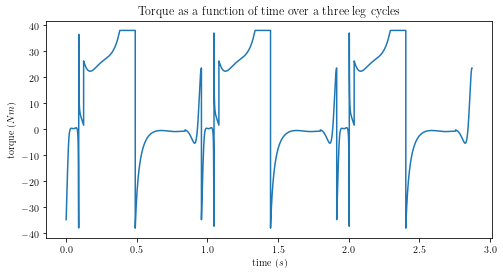

In [9]:
fig_torque = plt.figure(figsize=(8,4))
a_torque = plt.subplot()
a_torque.plot(time,torque)
a_torque.set_xlabel(r'time ($s$)')
a_torque.set_ylabel(r"torque ($Nm$)")
a_torque.set_title(r'Torque as a function of time over a three leg cycles')
fig_torque.show()
plt.savefig('imgout/5_torque_invalid.png',dpi=600)

In [1]:
fig_R = plt.figure(figsize = (8,4))
fig_R.suptitle(r'Reaction forces ($N$) as a function of time ($s$)')
a_R1 = plt.subplot(331)
a_R1.plot(time,R1,label=r'$R_1$')
a_R1.legend()
a_R2 = plt.subplot(332)
a_R2.plot(time,R2,label=r'$R_2$')
a_R2.legend()
a_R3 = plt.subplot(333)
a_R3.plot(time,R3,label=r'$R_3$')
a_R3.legend()
a_R4 = plt.subplot(334)
a_R4.plot(time,R4,label=r'$R_4$')
a_R4.legend()
a_R5 = plt.subplot(335)
a_R5.plot(time,R5,label=r'$R_5$')
a_R5.legend()
a_R6 = plt.subplot(336)
a_R6.plot(time,R6,label=r'$R_6$')
a_R6.legend()
a_R7 = plt.subplot(337)
a_R7.plot(time,R7,label=r'$R_7$')
a_R7.legend()
a_R8 = plt.subplot(338)
a_R8.plot(time,R8,label=r'$R_8$')
a_R8.legend()
a_R9 = plt.subplot(339)
a_R9.plot(time,R9,label=r'$R_9$')
a_R9.legend()
fig_R.show()
plt.savefig('imgout/5_reactions_over_time_invalid.png',dpi=600)

NameError: name 'plt' is not defined

In [ ]:
plt.plot(time,theta)

In [ ]:
maxR2 = np.amax(R2)
index = np.where(R2 == maxR2)[0][0]
print('index of highest torque:',index)
print('theta before:',theta[index])
print('theta after:',theta[index])
print('ground contact at:',theta[i_begin])
print('liftoff at:',theta[i_end])
offset = 1000
lower = index-offset
upper= index+offset
plt.plot(time[lower:upper],R2[lower:upper])

In [ ]:
fig_thetas = plt.figure()
fig_thetas.suptitle('Angles theta (rad) as function of time')
a_theta1 = plt.subplot(431)
a_theta1.plot(time,thetas1,'r',label='theta1')
a_theta1.legend()
a_theta2 = plt.subplot(432)
a_theta2.plot(time,thetas2,'r',label='theta2')
a_theta2.legend()
a_theta3 = plt.subplot(433)
a_theta3.plot(time,thetas3,'r',label='theta3')
a_theta3.legend()
a_theta4 = plt.subplot(434)
a_theta4.plot(time,thetas4,'r',label='theta4')
a_theta4.legend()
a_theta5 = plt.subplot(435)
a_theta5.plot(time,thetas5,'r',label='theta5')
a_theta5.legend()
a_theta6 = plt.subplot(436)
a_theta6.plot(time,thetas6,'r',label='theta6')
a_theta6.legend()
a_theta7 = plt.subplot(437)
a_theta7.plot(time,thetas7,'r',label='theta7')
a_theta7.legend()
a_theta8 = plt.subplot(438)
a_theta8.plot(time,thetas8,'r',label='theta8')
a_theta8.legend()
a_theta9 = plt.subplot(339)
a_theta9.plot(time,thetas9,'r',label='theta9')
a_theta9.legend()
plt.savefig('imgout/thetas_over_time.png',dpi=600)

In [ ]:
fig_tanthetas = plt.figure()
fig_tanthetas.suptitle(r'$\tan\theta_i$ as function of time')
a_tantheta1 = plt.subplot(431)
a_tantheta1.plot(time,np.tan(thetas1),'r',label=r'$\tan\theta_1$')
a_tantheta1.legend()
a_tantheta2 = plt.subplot(432)
a_tantheta2.plot(time,np.tan(thetas2),'r',label=r'$\tan\theta_2$')
a_tantheta2.legend()
a_tantheta3 = plt.subplot(433)
a_tantheta3.plot(time,np.tan(thetas3),'r',label=r'$\tan\theta_3$')
a_tantheta3.legend()
a_tantheta4 = plt.subplot(434)
a_tantheta4.plot(time,np.tan(thetas4),'r',label=r'$\tan\theta_4$')
a_tantheta4.legend()
a_tantheta5 = plt.subplot(435)
a_tantheta5.plot(time,np.tan(thetas5),'r',label=r'$\tan\theta_5$')
a_tantheta5.legend()
a_tantheta6 = plt.subplot(436)
a_tantheta6.plot(time,np.tan(thetas6),'r',label=r'$\tan\theta_6$')
a_tantheta6.legend()
a_tantheta7 = plt.subplot(437)
a_tantheta7.plot(time,np.tan(thetas7),'r',label=r'$\tan\theta_7$')
a_tantheta7.legend()
a_tantheta8 = plt.subplot(438)
a_tantheta8.plot(time,np.tan(thetas8),'r',label=r'$\tan\theta_8$')
a_tantheta8.legend()
a_tantheta9 = plt.subplot(339)
a_tantheta9.plot(time,np.tan(thetas9),'r',label=r'$\tan\theta_9$')
a_tantheta9.legend()
plt.savefig('imgout/5_tan_thetas_over_time.png',dpi=600)

In [ ]:
fig_numR = plt.figure()
fig_numR.suptitle('numerator of $R_i$ as function of time')
a_numR1 = plt.subplot(431)
a_numR1.plot(time,R1num,'r',label='numerator(R1)')
a_numR1.legend()
a_numR2 = plt.subplot(432)
a_numR2.plot(time,R2num,'r',label='numerator(R2)')
a_numR2.legend()
a_numR3 = plt.subplot(433)
a_numR3.plot(time,R3num,'r',label='numerator(R3)')
a_numR3.legend()
a_numR4 = plt.subplot(434)
a_numR4.plot(time,R4num,'r',label='numerator(R4)')
a_numR4.legend()
a_numR5 = plt.subplot(435)
a_numR5.plot(time,R5num,'r',label='numerator(R5)')
a_numR5.legend()
a_numR6 = plt.subplot(436)
a_numR6.plot(time,R6num,'r',label='numerator(R6)')
a_numR6.legend()
a_numR7 = plt.subplot(437)
a_numR7.plot(time,R7num,'r',label='numerator(R7)')
a_numR7.legend()
a_numR8 = plt.subplot(438)
a_numR8.plot(time,R8num,'r',label='numerator(R8)')
a_numR8.legend()
a_numR9 = plt.subplot(339)
a_numR9.plot(time,R9num,'r',label='numerator(R9)')
a_numR9.legend()
plt.savefig('imgout/R_numerator_over_time.png',dpi=600)

In [ ]:
fig_denR = plt.figure()
fig_denR.suptitle('denominator of $R_i$ as function of time')
a_denR1 = plt.subplot(431)
a_denR1.plot(time,R1den,'r',label='denominator(R1)')
a_denR1.legend()
a_denR2 = plt.subplot(432)
a_denR2.plot(time,R2den,'r',label='denominator(R2)')
a_denR2.legend()
a_denR3 = plt.subplot(433)
a_denR3.plot(time,R3den,'r',label='denominator(R3)')
a_denR3.legend()
a_denR4 = plt.subplot(434)
a_denR4.plot(time,R4den,'r',label='denominator(R4)')
a_denR4.legend()
a_denR5 = plt.subplot(435)
a_denR5.plot(time,R5den,'r',label='denominator(R5)')
a_denR5.legend()
a_denR6 = plt.subplot(436)
a_denR6.plot(time,R6den,'r',label='denominator(R6)')
a_denR6.legend()
a_denR7 = plt.subplot(437)
a_denR7.plot(time,R7den,'r',label='denominator(R7)')
a_denR7.legend()
a_denR8 = plt.subplot(438)
a_denR8.plot(time,R8den,'r',label='denominator(R8)')
a_denR8.legend()
a_denR9 = plt.subplot(339)
a_denR9.plot(time,R9den,'r',label='denominator(R9)')
a_denR9.legend()
plt.savefig('imgout/R_denominator_over_time.png',dpi=600)

In [ ]:
#plt.plot(time,R5*(np.sin(thetas5) - np.cos(thetas5)*np.tan(thetas6)))
#plt.plot(time, R7*(np.sin(thetas6)-np.cos(thetas7)*np.tan(thetas6)))
frst = np.empty(steps)
for i in range(0,steps,1):
    frst[i] = (m6+m8)*(y3dd(time[i]) + g - x3dd(time[i])*np.tan(thetas3[i]))
#plt.plot(time, (m6+m8)*(y3dd(time) + g - x3dd(time)*np.tan(thetas3[i])))
plt.plot(time, frst)

In [ ]:
scd = np.empty(steps)
for i in range(0,steps,1):
    scd[i] = x3dd(time[i])
plt.plot(time,scd)

In [ ]:
th3 = np.empty(steps)
for i in range(0,steps,1):
    th3[i] = np.tan(thetas3[i])
plt.plot(time,th3)

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(time,R10)
plt.xlabel(r'time ($s$)')
plt.ylabel(r'Force ($N$)')
plt.title(r'Reaction $R_{10}$ as a function of time')
plt.savefig('imgout/5_R10.png',dpi=600)

In [ ]:
plt.plot(time,R10num)

In [ ]:
plt.plot(time,R10den)

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font',family='serif')

plt.figure(figsize=(8,4))
plt.plot(time,np.sin(thetas10),label=r"$\sin\theta_{10}$")
plt.plot(time,np.cos(thetas10) * np.tan(thetas2), label=r"$\cos\theta_{10} \tan\theta_2$")
plt.title(r"Denominator factors of $R_{10}$ as functions of time")
plt.xlabel(r"time ($s$)")
plt.ylabel(r"factor amplitude")
plt.legend()
plt.savefig('imgout/5_R10_denominator.png',dpi=600)

## Configuration during singularity

theta_0: [-177.7530384]


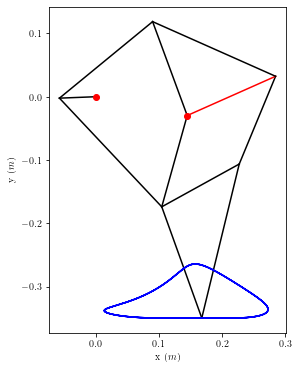

In [15]:
R10_max = np.amax(R10)
index = np.where(R10 == R10_max)
fig_vis = plt.figure(figsize=(6,6))
ax_vis = fig_vis.add_subplot()
ax_vis.plot([n3x[index],n5x[index]],[n3y[index],n5y[index]],color='k')
ax_vis.plot([n4x[index],n5x[index]],[n4y[index],n5y[index]],color='k')
ax_vis.plot([n3x[index],n4x[index]],[n3y[index],n4y[index]],color='k')
ax_vis.plot([n2x[index],n4x[index]],[n2y[index],n4y[index]],color='k')
ax_vis.plot([n0x[index],n3x[index]],[n0y[index],n3y[index]],color='k')
ax_vis.plot([[xpin],n3x[index]],[[ypin],n3y[index]],color='k')
ax_vis.plot([[xpin],n2x[index]],[[ypin],n2y[index]],color='r')
ax_vis.plot([n1x[index],n2x[index]],[n1y[index],n2y[index]],color='k')
ax_vis.plot([[xpin],n1x[index]],[[ypin],n1y[index]],color='k')
ax_vis.plot([n0x[index],n1x[index]],[n0y[index],n1y[index]],color='k')
ax_vis.plot([[0],n0x[index]],[[0],n0y[index]],color='k')
ax_vis.plot([0],[0],marker='o',color='r')
ax_vis.plot([xpin],[ypin],marker='o',color='r')
ax_vis.plot(n5x,n5y,color='b')
ax_vis.set_aspect('equal')
plt.xlabel('x ($m$)')
plt.ylabel('y ($m$)')
fig_vis.show()
plt.savefig('imgout/5_R10_overflow_singular_configuration_1.png',dpi=600)

print('theta_0:',np.arctan2(n0y[index],n0x[index])*(180/np.pi))


index: (array([12374]),)
theta_0: [153.3349476]


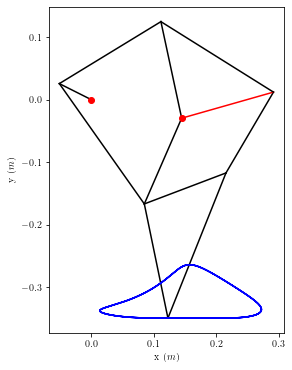

In [16]:
indices = np.argpartition(-R10,6)
index_val = np.amin(indices)
index = np.where(indices == index_val)
fig_vis2 = plt.figure(figsize=(6,6))
ax_vis2 = fig_vis2.add_subplot()
ax_vis2.plot([n3x[index],n5x[index]],[n3y[index],n5y[index]],color='k')
ax_vis2.plot([n4x[index],n5x[index]],[n4y[index],n5y[index]],color='k')
ax_vis2.plot([n3x[index],n4x[index]],[n3y[index],n4y[index]],color='k')
ax_vis2.plot([n2x[index],n4x[index]],[n2y[index],n4y[index]],color='k')
ax_vis2.plot([n0x[index],n3x[index]],[n0y[index],n3y[index]],color='k')
ax_vis2.plot([[xpin],n3x[index]],[[ypin],n3y[index]],color='k')
ax_vis2.plot([[xpin],n2x[index]],[[ypin],n2y[index]],color='r')
ax_vis2.plot([n1x[index],n2x[index]],[n1y[index],n2y[index]],color='k')
ax_vis2.plot([[xpin],n1x[index]],[[ypin],n1y[index]],color='k')
ax_vis2.plot([n0x[index],n1x[index]],[n0y[index],n1y[index]],color='k')
ax_vis2.plot([[0],n0x[index]],[[0],n0y[index]],color='k')
ax_vis2.plot([0],[0],marker='o',color='r')
ax_vis2.plot([xpin],[ypin],marker='o',color='r')
ax_vis2.plot(n5x,n5y,color='b')
ax_vis2.set_aspect('equal')
plt.xlabel('x ($m$)')
plt.ylabel('y ($m$)')
fig_vis2.show()
plt.savefig('imgout/5_R10_overflow_singular_configuration_2.png',dpi=600)

print('index:',index)
print('theta_0:',np.arctan2(n0y[index],n0x[index])*(180/np.pi))

## Output Key Data

In [ ]:
np.savetxt('foot_timings.csv',np.transpose(np.array([time,n5x,n5y])))
np.savetxt('jansen_data.csv',np.transpose(np.array([time,theta,torque,n5x,n5y])))

In [ ]:
plt.plot(time,n5x)
plt.plot(time,n5y)

In [ ]:
print(n5x[steps//3:(2*steps)//3].size)
print(steps//3)
print((2*steps)//3)

In [ ]:
fig_acc = plt.figure(figsize=(8,4))
fig_acc.suptitle(r'Joint accelerations ($\frac{m}{s^2}$) as function of time')
a_x0dd = plt.subplot(331)
a_x0dd.plot(time,x0dd_arr,'r',label='$x0_dd$',linewidth=1)
a_x0dd.plot(time,y0dd_arr,'b',label='$y0_dd$',linewidth=1)
a_x0dd.legend()
a_x1dd = plt.subplot(332)
a_x1dd.plot(time,x1dd_arr,'r',label='$x1_dd$',linewidth=1)
a_x1dd.plot(time,y1dd_arr,'b',label='$y1_dd$',linewidth=1)
a_x1dd.legend()
a_x2dd = plt.subplot(333)
a_x2dd.plot(time,x2dd_arr,'r',label='$x2_dd$',linewidth=1)
a_x2dd.plot(time,y2dd_arr,'b',label='$y2_dd$',linewidth=1)
a_x2dd.legend()
a_x3dd = plt.subplot(334)
a_x3dd.plot(time,x3dd_arr,'r',label='$x3_dd$',linewidth=1)
a_x3dd.plot(time,y3dd_arr,'b',label='$y3_dd$',linewidth=1)
a_x3dd.legend()
a_x4dd = plt.subplot(335)
a_x4dd.plot(time,x4dd_arr,'r',label='$x4_dd$',linewidth=1)
a_x4dd.plot(time,y4dd_arr,'b',label='$y4_dd$',linewidth=1)
a_x4dd.legend()
a_x5dd = plt.subplot(336)
a_x5dd.plot(time,x5dd_arr,'r',label='$x5_dd$',linewidth=1)
a_x5dd.plot(time,y5dd_arr,'b',label='$y5_dd$',linewidth=1)
a_x5dd.legend()
plt.savefig('imgout/positiondd_over_time.png',dpi=600)